\begin{center}
  \vfill
  A case study using real world data to formulate optimized dedication, immunization, and other bond portfolios. 
  \vspace{0.8cm}


  \includegraphics[width=0.4\textwidth]{lehigh-logo-print}
\end{center}

\pagebreak

\tableofcontents 

\pagebreak

In [1]:
# Hide
'''
Package Imports
'''
import pandas as pd
import numpy as np
import pulp
from pulp import *
import datetime
import matplotlib.pyplot as plt

import FinOpsCodeDeck as finops

from IPython.display import Markdown as md


# Term Structure

Determine the current term structure of treasury rates (see textbook Section 3.4 or other resources that you can find), and find the present value, duration, and convexity of the stream of liabilities. Please explain the main steps followed in your calculations.  Use real world data.

## Deriving Term Structure

In this section, we describe our derivation of the term structure of interest rates.  Specifically, we outline our data gathering and transformation techniques and then move to explaining bootstrapping.

### Data and Transformations

We begin by pulling current US Treasury issued Bonds and Notes from The [Wall Street Journal](https://www.wsj.com/market-data/bonds/treasuries).  We transform this data so we can understand each bonds market.  Specifically, we create a bid and ask price for each bond called `'px_bid'` or `'px_ask'`.  We also take the maturity of the bond minus today's date to get a time to maturity field called `'ttm'`.  This time to maturity is a float datatype which represents the years to maturity according to an actual/365 day calendar, the standard calendar of US Treasury Bonds.  For sake of simplicity, we use this calendar for the notes as well despite these operating on a 30/360 calendar.  Having completed these transformations, we can move to bootstrapping the curve.

### Bootstrapping

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(finance)) is a technique used to find continuous annualized interest rates across all time to maturities.  Due to the nature of fixed income securities paying intermediate coupons, bootstrapping is necessary to value a cashflow from one specific point in time to any other.  To better understand this, consider the following example.

*Example*  
Let the current market only consist of 2 risk-free bonds that were issued today:  
* 1-year zero-coupon bond trading at 99c on the dollar  
* 2-year 1.5% annual coupon bond trading at par  
To bootstrap the curve, we start with the 1-year zero.
$$99=100\mathrm{exp}\{-r\}\implies r=-\mathrm{log}(0.99)\approx0.01$$
We then use this rate in our calculation with the coupon bond to find the 2-year rate.
$$100 = 1.5\mathrm{exp}\{-0.01(1)\} + 101.5\mathrm{exp}\{-2r\} \implies r\approx0.0145$$
In this example, we have found the term structure to be given by:  

| Time to Maturity | Rate |  
| -- | -- |  
| 1 | 1.00% |  
| 2 | 1.45% |  

So, doing this over all cashflows of all bonds in our data will allow us to derive a term structure across all maturities.  This derived term structure will drive our analysis.

**NOTE**: For sake of simplicity, we round all time to maturity to the nearest hundredth of a year.  From a bond trading perspective, this is essentially every 2.5 trading days representing 1 time period.  We do this for simplicity in later sections as not all dates marry exactly together.  In the event that a particular liability does not have a term structure rate associated with it, we use the closest prior known date.  Additionally, in the event there are multiple calculated  yields for a particular time to maturity, we take the arithmetic average of them for that time.

\footnotesize

In [2]:
# Hide
'''
Data Import for Current Term Structure
---
Imports all active treasury bonds data, time indexes them by year
'''
data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')
data_prompt = data_prompt/1000
term_structure_df = pd.read_excel('TableNew.xlsx', sheet_name='d')
term_structure_df['px_ask'] = [i if i>=5 else 100 - i for i in term_structure_df['ASKED'].to_list()]
term_structure_df['px_bid'] = [i if i>=5 else 100 - i for i in term_structure_df['BID'].to_list()]
term_structure_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in term_structure_df['MATURITY']]

In [3]:
'''
Bootstrap yield curve
---
begins with zero-coupon bonds to payout (ttm < 0.5 yrs) & calculates yield
moves to coupon bonds and uses calculated yields to bootstrap further
sorts all bonds into data frame indexed by ttm (by 100th of a year)
NOTE: Averages yields for the same time period
NOTE: assumes yield of period prior if yield for desired period does not exist
'''

'''short term rates'''
mats = []
round_to = 2
for bond_tenor in term_structure_df[term_structure_df['ttm'] <= 0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    cpn = bond['COUPON']/2
    ttm = bond['ttm']
    px = bond['px_ask']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_ask']) / bond['ttm']])
rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

'''longer term rates'''
for bond_tenor in term_structure_df[term_structure_df['ttm']>=0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    px = bond['px_ask']
    ttm = bond['ttm']
    cpn = bond['COUPON']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    rates = pd.concat([rates,add_df],ignore_index=False)
    rates = rates.groupby('ttm').mean()

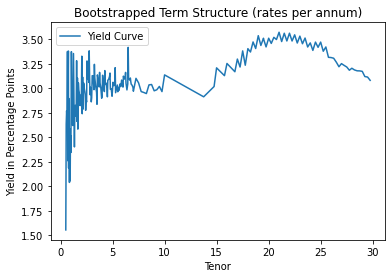

In [4]:
'''
plot yield curve
---
plots yield curve in percentage points
'''
plt.plot(rates[0.5:] * 100)
plt.title('Bootstrapped Term Structure (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')
plt.legend(['Yield Curve'])

In [5]:
'''
Liability Stream Analysis
---
Calculates time to maturity (in years) of each obligation
Calculates npv, duration, and convexity of liability stream
Prints stats to markdown for viewing
'''
data_prompt['ttm'] = np.round((data_prompt.index - datetime.datetime.now()) / datetime.timedelta(days=365), round_to)
r = [rates[:ttm].iloc[-1,0] for ttm in data_prompt['ttm']]
data_prompt['rates'] = r

npv = sum([data_prompt.iloc[i,0]*np.exp((-1)*data_prompt.iloc[i,1]*data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
dur = sum([data_prompt.iloc[i,0]*data_prompt.iloc[i,1]*np.exp((-1) * (data_prompt.iloc[i,1]+1)*data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
con = sum([data_prompt.iloc[i,0]*data_prompt.iloc[i,1]*(data_prompt.iloc[i,1]+1)*np.exp((-1)*(data_prompt.iloc[i,1]+2)*data_prompt.iloc[i,2]) for i in range(len(data_prompt))])



\normalsize

In [6]:
md('''
<center>

The Net Present Value of the Liabilities is $\${:.2f}$ MM

The Macauley Duration of the Liability stream is ${:.2f}$ years

The Convexity of the Liability stream is ${:.2f}$


'''.format(npv,dur/npv,con/npv))


<center>

The Net Present Value of the Liabilities is $\$117.66$ MM

The Macauley Duration of the Liability stream is $3.83$ years

The Convexity of the Liability stream is $23.31$




# Data

Identify *at least* 30 fixed-income assets that are suitable to construct a dedicated bond portfolio for the municipality liabilities that you have been given. Use assets that are considered risk-free; for example, US government non-callable treasury bonds, treasury bills, or treasury notes. Display in an appropriate table the main characteristics of the bonds you choose. Namely, prices, coupon rates, maturity dates, face value).

In [7]:
'''
Clean Data
'''
ref_data = ['T ' + '{:.3f}'.format(term_structure_df.iloc[bond,1]) + ' ' + term_structure_df.iloc[bond,0].strftime('%m/%d/%y') for bond in term_structure_df.index]
term_structure_df['ref_data'] = ref_data

bonds_clean = term_structure_df[['ref_data', 'px_ask', 'ASKED YIELD']]
bonds_clean.columns = ['Bond', 'Price', 'Yield']
# bonds_clean = bonds_clean.assign(ttm = term_structure_df.ttm.round(2))
bonds_clean = bonds_clean.set_index('Bond')

In [8]:
# Hide
list_for_slice = bonds_clean.index.tolist()
bond_dis1 = bonds_clean.loc[:list_for_slice[len(list_for_slice)//4-1],:].reset_index()
bond_dis2 = bonds_clean.loc[list_for_slice[len(list_for_slice)//4]:list_for_slice[len(list_for_slice)//2-1],:].reset_index()
bond_dis3 = bonds_clean.loc[list_for_slice[len(list_for_slice)//2]:list_for_slice[(3*len(list_for_slice))//4-1],:].reset_index()
bond_dis4 = bonds_clean.loc[list_for_slice[(3*len(list_for_slice))//4]:,:].reset_index()
multi_col = [(i, j) for i in range(1,5) for j in bond_dis4.columns.to_list()]
side_by_side = pd.DataFrame(index=range(1,92), columns=pd.MultiIndex.from_tuples(multi_col))

dis_dict = dict(zip(range(1,5), [bond_dis1, bond_dis2, bond_dis3, bond_dis4]))
for i in range(1,5):
    for j in bond_dis4.columns.to_list():
        side_by_side.loc[:, (i, j)] = dis_dict[i][j].to_list()
almost_dis = side_by_side.set_index((1, 'Bond'),).droplevel(level=0, axis=1)
almost_dis
almost_dis.index.name = 'Bond'
almost_dis
alignment = tuple(['center' for i in range(12)])

\footnotesize

In [9]:
# Hide
md('''

{} 

'''.format(almost_dis.to_markdown(colalign = alignment)))



|       Bond       |  Price  |  Yield  |       Bond       |  Price  |  Yield  |       Bond       |  Price  |  Yield  |       Bond       |  Price  |  Yield  |
|:----------------:|:-------:|:-------:|:----------------:|:-------:|:-------:|:----------------:|:-------:|:-------:|:----------------:|:-------:|:-------:|
| T 1.750 05/15/22 | 100.01  | -1.9931 | T 1.625 04/30/23 |  99.19  |  2.056  | T 2.625 04/15/25 | 99.164  |  2.799  | T 5.250 11/15/28 | 113.192 |  2.935  |
| T 2.125 05/15/22 | 100.012 | -2.5447 | T 2.750 04/30/23 | 100.206 |  2.061  | T 0.375 04/30/25 |  93.04  |  2.815  | T 1.500 11/30/28 | 91.112  |  2.964  |
| T 0.000 05/17/22 | 99.352  |  0.657  | T 0.125 05/15/23 |  98.03  |  2.066  | T 2.875 04/30/25 | 100.066 |   2.8   | T 1.375 12/31/28 | 90.194  |  2.946  |
| T 0.000 05/19/22 |  99.34  |  0.669  | T 1.750 05/15/23 |  99.22  |  2.068  | T 2.125 05/15/25 | 98.016  |  2.806  | T 1.750 01/31/29 | 92.234  |  2.951  |
| T 0.000 05/24/22 |  99.32  |  0.69   | T 0.125 05/31/23 | 97.306  |  2.115  | T 2.750 05/15/25 | 99.282  |  2.791  | T 2.625 02/15/29 |  98.01  |  2.948  |
| T 0.000 05/26/22 | 99.322  |  0.687  | T 1.625 05/31/23 | 99.156  |  2.12   | T 0.250 05/31/25 | 92.186  |  2.811  | T 5.250 02/15/29 | 114.03  |  2.933  |
| T 0.125 05/31/22 | 99.312  | 0.6946  | T 2.750 05/31/23 | 100.204 |  2.124  | T 2.875 05/31/25 | 100.066 |  2.802  | T 1.875 02/28/29 | 93.152  |  2.942  |
| T 1.750 05/31/22 | 100.014 |  0.608  | T 0.250 06/15/23 | 97.316  |  2.136  | T 0.250 06/30/25 | 92.116  |  2.819  | T 2.375 03/31/29 |  96.14  |  2.951  |
| T 1.875 05/31/22 | 100.016 |  0.544  | T 0.125 06/30/23 |  97.23  |  2.19   | T 2.750 06/30/25 | 99.266  |  2.805  | T 2.875 04/30/29 | 99.172  |  2.949  |
| T 0.000 05/31/22 | 99.307  |  0.702  | T 1.375 06/30/23 | 99.034  |  2.181  | T 0.250 07/31/25 | 92.046  |  2.826  | T 2.375 05/15/29 | 96.134  |  2.945  |
| T 0.000 06/02/22 | 99.327  |  0.682  | T 2.625 06/30/23 | 100.156 |  2.178  | T 2.875 07/31/25 | 100.06  |  2.813  | T 1.625 08/15/29 | 91.192  |  2.918  |
| T 0.000 06/07/22 | 99.352  |  0.657  | T 0.125 07/15/23 |  97.19  |  2.227  | T 2.000 08/15/25 | 97.136  |  2.833  | T 6.125 08/15/29 | 120.284 |  2.908  |
| T 0.000 06/09/22 | 99.347  |  0.662  | T 0.125 07/31/23 | 97.144  |  2.271  | T 6.875 08/15/25 | 112.206 |  2.778  | T 1.750 11/15/29 | 92.076  |  2.909  |
| T 0.000 06/14/22 |  99.35  |  0.659  | T 1.250 07/31/23 | 98.262  |  2.243  | T 0.250 08/31/25 |  91.29  |  2.844  | T 1.500 02/15/30 | 90.076  |  2.915  |
| T 1.750 06/15/22 | 100.03  |  0.608  | T 2.750 07/31/23 | 100.19  |  2.248  | T 2.750 08/31/25 |  99.23  |  2.839  | T 0.625 05/15/30 |  83.23  |  2.923  |
| T 0.000 06/16/22 | 99.372  |  0.637  | T 0.125 08/15/23 | 97.114  |  2.277  | T 0.250 09/30/25 | 91.224  |  2.846  | T 6.250 05/15/30 | 123.232 |  2.904  |
| T 0.000 06/21/22 | 99.342  |  0.667  | T 2.500 08/15/23 | 100.094 |  2.257  | T 3.000 09/30/25 | 100.166 |  2.836  | T 0.625 08/15/30 |  83.09  |  2.92   |
| T 0.000 06/23/22 | 99.307  |  0.703  | T 6.250 08/15/23 | 104.296 |  2.23   | T 0.250 10/31/25 |  91.16  |  2.85   | T 0.875 11/15/30 | 84.224  |  2.921  |
| T 0.000 06/28/22 | 99.275  |  0.736  | T 0.125 08/31/23 | 97.062  |  2.344  | T 3.000 10/31/25 | 100.156 |  2.849  | T 1.125 02/15/31 | 86.076  |  2.918  |
| T 0.125 06/30/22 | 99.294  |  0.755  | T 1.375 08/31/23 |  98.26  |  2.313  | T 2.250 11/15/25 | 98.004  |  2.85   | T 5.375 02/15/31 | 118.256 |  2.923  |
| T 1.750 06/30/22 | 100.04  |  0.74   | T 2.750 08/31/23 | 100.176 |  2.31   | T 0.375 11/30/25 | 91.224  |  2.855  | T 1.625 05/15/31 |  89.25  |  2.925  |
| T 2.125 06/30/22 | 100.052 |  0.799  | T 0.125 09/15/23 |  97.04  |  2.33   | T 2.875 11/30/25 | 100.026 |  2.849  | T 1.250 08/15/31 | 86.162  |  2.925  |
| T 0.000 06/30/22 | 99.275  |  0.736  | T 0.250 09/30/23 | 97.056  |  2.347  | T 0.375 12/31/25 | 91.166  |  2.853  | T 1.375 11/15/31 | 87.046  |  2.935  |
| T 0.000 07/05/22 |  99.26  |  0.751  | T 1.375 09/30/23 | 98.222  |  2.345  | T 2.625 12/31/25 |  99.09  |  2.835  | T 1.875 02/15/32 |  91.02  |  2.936  |
| T 0.000 07/07/22 | 99.235  |  0.777  | T 2.875 09/30/23 | 100.23  |  2.339  | T 0.375 01/31/26 | 91.094  |  2.864  | T 2.875 05/15/32 | 99.176  |  2.927  |
| T 0.000 07/12/22 | 99.237  |  0.774  | T 0.125 10/15/23 | 96.276  |  2.389  | T 2.625 01/31/26 | 99.062  |  2.855  | T 4.500 02/15/36 | 118.09  |  2.88   |
| T 0.000 07/14/22 | 99.222  |  0.789  | T 0.375 10/31/23 | 97.032  |  2.412  | T 1.625 02/15/26 | 95.194  |  2.867  | T 4.750 02/15/37 | 121.096 |  2.957  |
| T 1.750 07/15/22 | 100.052 |  0.756  | T 1.625 10/31/23 | 98.286  |  2.399  | T 6.000 02/15/26 | 111.052 |  2.84   | T 5.000 05/15/37 | 124.052 |  2.989  |
| T 0.000 07/21/22 |  99.21  |  0.802  | T 2.875 10/31/23 | 100.21  |  2.413  | T 0.500 02/28/26 |  91.18  |  2.865  | T 4.375 02/15/38 | 116.29  |  3.018  |
| T 0.000 07/28/22 | 99.205  |  0.807  | T 0.250 11/15/23 | 96.262  |  2.425  | T 2.500 02/28/26 | 98.232  |  2.856  | T 4.500 05/15/38 | 118.154 |  3.033  |
| T 0.125 07/31/22 |  99.27  |  0.871  | T 2.750 11/15/23 | 100.156 |  2.413  | T 0.750 03/31/26 | 92.092  |  2.867  | T 3.500 02/15/39 | 105.026 |  3.108  |
| T 1.875 07/31/22 | 100.064 |  0.902  | T 0.500 11/30/23 |  97.01  |  2.475  | T 2.250 03/31/26 |  97.24  |  2.867  | T 4.250 05/15/39 | 115.006 |  3.106  |
| T 2.000 07/31/22 | 100.072 |  0.915  | T 2.125 11/30/23 | 99.172  |  2.431  | T 0.750 04/30/26 | 92.042  |  2.868  | T 4.500 08/15/39 | 118.124 |  3.114  |
| T 0.000 08/04/22 | 99.085  |  0.93   | T 2.875 11/30/23 | 100.202 |  2.454  | T 2.375 04/30/26 | 98.062  |  2.861  | T 4.375 11/15/39 | 116.14  |  3.146  |
| T 0.000 08/11/22 | 99.055  |  0.96   | T 0.125 12/15/23 | 96.126  |  2.46   | T 1.625 05/15/26 | 95.094  |  2.879  | T 4.625 02/15/40 | 120.014 |  3.143  |
| T 1.500 08/15/22 | 100.04  |  0.999  | T 0.750 12/31/23 |  97.07  |  2.508  | T 0.750 05/31/26 | 91.292  |  2.884  | T 1.125 05/15/40 |  70.18  |  3.309  |
| T 1.625 08/15/22 | 100.05  |  0.999  | T 2.250 12/31/23 | 99.202  |  2.481  | T 2.125 05/31/26 |  97.05  |  2.875  | T 4.375 05/15/40 |  116.1  |  3.178  |
| T 7.250 08/15/22 | 101.184 |  0.942  | T 2.625 12/31/23 | 100.08  |  2.466  | T 0.875 06/30/26 | 92.074  |  2.886  | T 1.125 08/15/40 |  70.03  |  3.324  |
| T 0.000 08/18/22 |  99.01  |  1.006  | T 0.125 01/15/24 | 96.046  |   2.5   | T 1.875 06/30/26 | 96.052  |  2.868  | T 3.875 08/15/40 | 108.282 |  3.227  |
| T 0.000 08/25/22 |  99.01  |  1.007  | T 0.875 01/31/24 | 97.072  |  2.542  | T 0.625 07/31/26 | 91.024  |  2.891  | T 1.375 11/15/40 | 73.066  |  3.326  |
| T 0.125 08/31/22 | 99.234  |  1.042  | T 2.500 01/31/24 | 99.302  |  2.532  | T 1.875 07/31/26 | 96.024  |  2.87   | T 4.250 11/15/40 | 113.294 |  3.243  |
| T 1.625 08/31/22 | 100.052 |  1.057  | T 0.125 02/15/24 | 95.286  |  2.534  | T 1.500 08/15/26 | 94.144  |  2.896  | T 1.875 02/15/41 | 79.282  |  3.325  |
| T 1.875 08/31/22 | 100.076 |  1.037  | T 2.750 02/15/24 | 100.112 |  2.542  | T 6.750 08/15/26 | 115.122 |  2.878  | T 4.750 02/15/41 | 121.106 |  3.225  |
| T 0.000 09/01/22 | 98.957  |  1.06   | T 1.500 02/29/24 | 98.056  |  2.546  | T 0.750 08/31/26 | 91.134  |  2.89   | T 2.250 05/15/41 | 84.262  |  3.335  |
| T 0.000 09/08/22 | 98.912  |  1.106  | T 2.125 02/29/24 | 99.092  |  2.533  | T 1.375 08/31/26 | 93.302  |  2.885  | T 4.375 05/15/41 | 115.164 |  3.272  |
| T 1.500 09/15/22 | 100.03  |  1.214  | T 2.375 02/29/24 | 99.232  |  2.531  | T 0.875 09/30/26 | 91.246  |  2.89   | T 1.750 08/15/41 | 77.146  |  3.348  |
| T 0.000 09/15/22 |  98.9   |  1.12   | T 0.250 03/15/24 | 95.286  |  2.556  | T 1.625 09/30/26 | 94.262  |  2.894  | T 3.750 08/15/41 | 106.144 |  3.294  |
| T 0.000 09/22/22 | 98.885  |  1.135  | T 2.125 03/31/24 |  99.07  |  2.554  | T 1.125 10/31/26 |  92.21  |  2.893  | T 3.125 11/15/41 |  97.11  |  3.311  |
| T 0.000 09/29/22 | 98.887  |  1.133  | T 2.250 03/31/24 |  99.13  |  2.576  | T 1.625 10/31/26 | 94.234  |  2.893  | T 2.000 11/30/41 | 80.292  |  3.34   |
| T 0.125 09/30/22 | 99.184  |  1.258  | T 0.375 04/15/24 | 95.286  |  2.584  | T 2.000 11/15/26 |  96.07  |  2.903  | T 2.375 02/15/42 | 86.136  |  3.316  |
| T 1.750 09/30/22 | 100.056 |  1.266  | T 2.000 04/30/24 | 98.286  |  2.581  | T 6.500 11/15/26 | 115.034 |  2.893  | T 3.125 02/15/42 | 97.094  |  3.312  |
| T 1.875 09/30/22 | 100.074 |  1.244  | T 2.250 04/30/24 |  99.12  |  2.579  | T 1.250 11/30/26 | 93.032  |  2.882  | T 3.000 05/15/42 | 95.104  |  3.322  |
| T 0.000 10/06/22 | 98.845  |  1.176  | T 2.500 04/30/24 |  99.27  |  2.582  | T 1.625 11/30/26 | 94.222  |  2.879  | T 2.750 08/15/42 | 91.074  |  3.349  |
| T 0.000 10/13/22 | 98.757  |  1.266  | T 0.250 05/15/24 | 95.144  |  2.601  | T 1.250 12/31/26 | 92.304  |  2.889  | T 2.750 11/15/42 | 91.022  |  3.356  |
| T 1.375 10/15/22 | 100.004 |  1.336  | T 2.500 05/15/24 |  99.25  |  2.613  | T 1.750 12/31/26 | 95.034  |  2.887  | T 3.125 02/15/43 | 96.232  |  3.345  |
| T 0.000 10/20/22 | 98.732  |  1.292  | T 2.000 05/31/24 | 98.264  |  2.593  | T 1.500 01/31/27 | 93.292  |  2.891  | T 2.875 05/15/43 | 92.264  |  3.354  |
| T 0.000 10/27/22 | 98.697  |  1.329  | T 0.250 06/15/24 | 95.066  |  2.628  | T 2.250 02/15/27 | 97.042  |   2.9   | T 3.625 08/15/43 | 104.124 |  3.335  |
| T 0.125 10/31/22 |  99.14  |  1.365  | T 1.750 06/30/24 |  98.06  |  2.632  | T 6.625 02/15/27 | 116.114 |  2.912  | T 3.750 11/15/43 | 106.112 |  3.334  |
| T 1.875 10/31/22 | 100.072 |  1.375  | T 2.000 06/30/24 | 98.214  |  2.647  | T 1.125 02/28/27 | 92.052  |  2.888  | T 3.625 02/15/44 | 104.09  |  3.346  |
| T 2.000 10/31/22 | 100.09  |  1.379  | T 0.375 07/15/24 | 95.064  |  2.669  | T 1.875 02/28/27 | 95.172  |  2.878  | T 3.375 05/15/44 | 100.094 |  3.356  |
| T 0.000 11/03/22 | 98.675  |  1.352  | T 1.750 07/31/24 | 98.014  |  2.665  | T 0.625 03/31/27 | 89.244  |  2.891  | T 3.125 08/15/44 |  96.11  |  3.359  |
| T 0.000 11/10/22 | 98.605  |  1.424  | T 2.125 07/31/24 | 98.264  |  2.674  | T 2.500 03/31/27 |  98.09  |  2.88   | T 3.000 11/15/44 | 94.084  |  3.366  |
| T 1.625 11/15/22 | 100.022 |  1.483  | T 0.375 08/15/24 |  94.31  |  2.693  | T 0.500 04/30/27 | 89.002  |  2.897  | T 2.500 02/15/45 | 86.084  |  3.369  |
| T 7.625 11/15/22 | 103.032 |  1.346  | T 2.375 08/15/24 | 99.092  |  2.702  | T 2.750 04/30/27 | 99.126  |  2.881  | T 3.000 05/15/45 | 94.094  |  3.358  |
| T 0.125 11/30/22 |  99.08  |  1.522  | T 1.250 08/31/24 |  96.25  |  2.708  | T 2.375 05/15/27 | 97.164  |  2.913  | T 2.875 08/15/45 | 92.116  |  3.35   |
| T 2.000 11/30/22 | 100.084 |  1.505  | T 1.875 08/31/24 | 98.042  |  2.721  | T 0.500 05/31/27 |  88.24  |  2.916  | T 3.000 11/15/45 | 94.174  |  3.337  |
| T 0.000 12/01/22 |  98.64  |  1.389  | T 0.375 09/15/24 | 94.224  |  2.735  | T 0.500 06/30/27 | 88.184  |  2.916  | T 2.500 02/15/46 | 86.076  |  3.344  |
| T 1.625 12/15/22 | 100.012 |  1.557  | T 1.500 09/30/24 |  97.07  |  2.717  | T 0.375 07/31/27 | 87.274  |  2.903  | T 2.500 05/15/46 | 86.074  |  3.338  |
| T 0.000 12/29/22 | 98.515  |  1.52   | T 2.125 09/30/24 |  98.21  |  2.713  | T 2.250 08/15/27 |  96.24  |  2.922  | T 2.250 08/15/46 | 82.016  |  3.335  |
| T 0.137 12/31/22 | 99.016  |  1.653  | T 0.625 10/15/24 | 95.034  |  2.723  | T 6.375 08/15/27 | 116.224 |  2.92   | T 2.875 11/15/46 | 92.234  |  3.31   |
| T 2.125 12/31/22 | 100.09  |  1.669  | T 1.500 10/31/24 |  97.02  |  2.745  | T 0.500 08/31/27 |  88.06  |  2.926  | T 3.000 02/15/47 | 94.266  |  3.307  |
| T 1.500 01/15/23 | 99.274  |  1.712  | T 2.250 10/31/24 | 98.274  |  2.733  | T 0.500 10/31/27 | 87.262  |  2.932  | T 3.000 05/15/47 | 94.282  |  3.302  |
| T 0.000 01/26/23 | 98.452  |  1.586  | T 0.750 11/15/24 | 95.054  |  2.752  | T 2.250 11/15/27 | 96.186  |  2.927  | T 2.750 08/15/47 | 90.276  |  3.285  |
| T 0.125 01/31/23 |  98.27  |  1.771  | T 2.250 11/15/24 | 98.244  |  2.765  | T 6.125 11/15/27 | 116.04  |  2.928  | T 2.750 11/15/47 | 90.302  |  3.277  |
| T 1.750 01/31/23 |   100   |  1.749  | T 7.500 11/15/24 | 111.176 |  2.685  | T 0.625 11/30/27 | 88.082  |  2.937  | T 3.000 02/15/48 |  95.21  |  3.25   |
| T 2.375 01/31/23 | 100.142 |  1.739  | T 1.500 11/30/24 | 96.292  |  2.766  | T 0.625 12/31/27 |  88.02  |  2.944  | T 3.125 05/15/48 |  98.04  |  3.232  |
| T 1.375 02/15/23 |  99.22  |  1.795  | T 2.125 11/30/24 | 98.142  |  2.763  | T 0.750 01/31/28 | 88.166  |  2.949  | T 3.000 08/15/48 | 95.242  |  3.241  |
| T 2.000 02/15/23 | 100.05  |  1.788  | T 1.000 12/15/24 | 95.204  |  2.758  | T 2.750 02/15/28 | 99.004  |  2.937  | T 3.375 11/15/48 | 103.004 |  3.205  |
| T 7.125 02/15/23 | 104.006 |  1.708  | T 1.750 12/31/24 | 97.134  |  2.775  | T 1.125 02/29/28 | 90.136  |  2.934  | T 3.000 02/15/49 | 96.142  |  3.199  |
| T 0.000 02/23/23 | 98.332  |  1.713  | T 2.250 12/31/24 |  98.22  |  2.771  | T 1.250 03/31/28 | 90.284  |  2.95   | T 2.875 05/15/49 | 94.084  |  3.194  |
| T 0.125 02/28/23 | 98.206  |  1.855  | T 1.125 01/15/25 |  95.25  |  2.777  | T 1.250 04/30/28 |  90.24  |  2.955  | T 2.250 08/15/49 | 82.304  |  3.191  |
| T 1.500 02/28/23 | 99.232  |  1.849  | T 1.375 01/31/25 | 96.114  |  2.779  | T 2.875 05/15/28 | 99.192  |  2.948  | T 2.375 11/15/49 | 85.126  |  3.175  |
| T 2.625 02/28/23 | 100.192 |  1.853  | T 2.500 01/31/25 |  99.09  |  2.776  | T 1.250 05/31/28 |  90.2   |  2.956  | T 2.000 02/15/50 | 78.066  |  3.189  |
| T 0.500 03/15/23 | 98.276  |  1.879  | T 1.500 02/15/25 | 96.184  |  2.798  | T 1.250 06/30/28 | 90.146  |  2.965  | T 1.250 05/15/50 | 64.106  |  3.184  |
| T 0.000 03/23/23 | 98.282  |  1.772  | T 2.000 02/15/25 | 97.296  |  2.786  | T 1.000 07/31/28 | 88.296  |  2.965  | T 1.375 08/15/50 | 66.176  |  3.177  |
| T 0.125 03/31/23 | 98.134  |  1.954  | T 7.625 02/15/25 | 112.286 |  2.725  | T 2.875 08/15/28 | 99.162  |  2.961  | T 1.625 11/15/50 |  71.07  |  3.166  |
| T 1.500 03/31/23 |  99.19  |  1.97   | T 1.125 02/28/25 | 95.186  |  2.779  | T 5.500 08/15/28 | 114.156 |  2.944  | T 1.875 02/15/51 |  75.31  |  3.152  |
| T 2.500 03/31/23 | 100.146 |  1.964  | T 2.750 02/28/25 | 99.286  |  2.787  | T 1.125 08/31/28 | 89.164  |  2.964  | T 2.375 05/15/51 | 85.156  |  3.141  |
| T 0.250 04/15/23 |  98.13  |  2.016  | T 1.750 03/15/25 | 97.052  |  2.798  | T 1.250 09/30/28 | 90.026  |  2.968  | T 2.000 08/15/51 | 78.106  |  3.137  |
| T 0.000 04/20/23 | 98.127  |  1.933  | T 0.500 03/31/25 | 93.222  |  2.798  | T 1.375 10/31/28 | 90.226  |  2.966  | T 1.875 11/15/51 | 76.014  |  3.124  |
| T 0.125 04/30/23 | 98.056  |  2.057  | T 2.625 03/31/25 | 99.176  |  2.787  | T 3.125 11/15/28 | 100.312 |  2.959  | T 2.250 02/15/52 | 83.134  |  3.108  | 



\normalsize

# Dedication Portfolio

## Prompt

Formulate a linear programming model to find the lowest cost bond dedicated portfolio that covers the stream of liabilities. To eliminate the possibility of any interest risk, assume that a 0% reinvestment rate on cash balances carried out from one date to the next. Assume no short selling of bonds is allowed. What is the cost of your portfolio? How does this cost compares with the NPV of the liabilities? What is the composition of the portfolio?

## Mathematical Formulation

$$
\begin{split}
\text{min} \ \ \ &  z_0 + \sum_{i=1}^NP_ix_i \\
\\
\text{s.t.} \ \ \ & \sum_{i=1,\dots, \ n: \ M_i > t-1}C_ix_i + \sum_{i=1,\dots, \ n: \ M_i = t}100x_i + (1+r_f) z_{t-1} -z_t = L_t \ \ \ \ \text{for t} \in \{1,\dots, 16 \} \\
\text{where, }\\
& P_i: \text{Price of the bond } i = 1,\dots,N \\
& x_i: \text{the amount purchased of bond } i = 1,\dots,N \\
& z_t: \text{Excess cashflows after Liability as been paid for period } t = 1,\dots,16  \\
& C_{i}: \text{The coupon payment from bond } i = 1,\dots,N \\
& L_t: \text{Liability in period } t = 1,\dots,16 \\
& M_i: \text{The maturity year of bond} i = 1,\dots,N \\
& r_f: \text{the risk free rate that will be used as the carrying interest for our last period surplus} \\
\end{split}
$$

In a dedication protfolio we are "cash matching". By this we mean to match the sum total of Cash Flows from our pruchased fixed income assets for every and all period Liabilties. We must state that we are not allowed to take a short position in any stock therefore, we are trying minimize the cost of the purchases portfolio to meet our liabilities. We have a surplus term that will account for our excess cash flows after liabiltiies paid for a certain period. These funds may be used for a period in which the inflow from the bonds is not enough to cover liabilties. 

**NOTE**: The objective of this problem does have the risk-free rate as 0% on assumption. Thus the interest earned term is just  $ (1+r_f)z_{t-1} = z_{t-1}$



## Code

\scriptsize

In [10]:
'''
Data Manipulation
'''
term_by_maturity = term_structure_df.set_index('MATURITY')
possibilities = term_by_maturity.drop(
    index=[i for i in term_by_maturity.index.to_list() if i > data_prompt.index.to_list()[-1]],
    columns=['BID', 'ASKED', 'ASKED YIELD']
    )

'''List of bond maturities less than liability maturity'''
date_lists_to_change_to_periods = [
    [i for i in possibilities.index.to_list() if i <= t]
    for t in data_prompt.index.tolist()
    ]
'''Removing the duplicates from each one'''
for i in reversed(range(1,len(date_lists_to_change_to_periods))):
    for j in range(0,len(date_lists_to_change_to_periods[i-1])):
        date_lists_to_change_to_periods[i].remove(date_lists_to_change_to_periods[i-1][j])

for i in range(0,len(date_lists_to_change_to_periods)):
    possibilities.loc[date_lists_to_change_to_periods[i],'period'] = i+1

possibilities['face'] = 100
possibilities['bond#'] = range(1,len(possibilities)+1)
possibilities = possibilities.set_index('bond#')

'''for labeling later'''
dec_var_names = possibilities['ref_data']

In [11]:
'''Getting data ready for the solver'''

'''Exmpty Array'''
cfs = np.zeros((len(possibilities),len(date_lists_to_change_to_periods)))

'''CF Matrix'''
for i in range(0, len(cfs)):
    for j in range(1, len(cfs[0])+1):
        if possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] == 0:
            cfs[i][j-1] = possibilities.loc[i+1,'face']
        elif possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] != 0:
            cfs[i][0:j-1] = possibilities.loc[i+1,'COUPON']/2
            cfs[i][j-1] = possibilities.loc[i+1,'face'] + possibilities.loc[i+1,'COUPON']/2

cf_matrix = cfs.tolist()
prices = possibilities['px_ask'].values.tolist()
liabilities = data_prompt['Amount'].values.tolist()

In [12]:
'''Solving for the dedicated portfolio'''

# Making variable list of strings
periods = [i for i in range(0,len(cf_matrix[0])+1)]

# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(dec_var_names,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))

objective = dict(zip(dec_var_names, prices))

# Decision Vars
quantity = LpVariable.dict('', dec_var_names, lowBound=0)
excess = LpVariable.dict('ExcessCF', periods, lowBound=0)

# Intializing the Problem
dedication_1 = LpProblem('Dedicated', LpMinimize)

# Objective function
dedication_1 += excess[0]+lpSum([objective[i]*quantity[i] for i in dec_var_names])

# Constraints
for i in range(0,len(cf_matrix[0])):
    dedication_1 += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity[j] for j in dec_var_names]) + excess[i]- excess[i+1] == liabilities[i]

dedication_1.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/f86a497703534e048081a3a8183b6760-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/f86a497703534e048081a3a8183b6760-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21 COLUMNS
At line 1892 RHS
At line 1909 BOUNDS
At line 1910 ENDATA
Problem MODEL has 16 rows, 306 columns and 1580 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 16 (0) rows, 161 (-145) columns and 1116 (-464) elements
0  Obj 0 Primal inf 1.2901585 (16)
31  Obj 117.77454
Optimal - objective value 117.77454
After Postsolve, objective 117.77454, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 117.7745377 - 31 iterations time

1

\normalsize

## Cost and Composition

In [13]:
'''
Print Solution to dedication_1 portfolio
'''
ded_df = pd.DataFrame(
    [v.varValue for v in dedication_1.variables() if v.varValue != 0],
    index=[str(v.name[1:9].replace('_', ' ') + v.name[9:].replace('_', '/')) 
        if v.name[0] != 'E'
        else str(r'$\text{' + v.name[:-2] + '}' + v.name[-2:] + '$') for v in [g for g in dedication_1.variables() if g.varValue != 0]],
    columns=['Quantity']
    )
mature = ['20'+ i[-2:] + '-'+i[-8:-6] + '-'+i[-5:-3]
    if i[0] != 'E' 
    else '2100-01-01'
    for i in ded_df.index.tolist()]
bond_s_dis = ded_df.reset_index()
bond_s_dis['m'] = mature
bond_s_dis.set_index('m', inplace=True)
bond_s_dis.sort_index(inplace=True)
bond_s_dis.set_index('index', inplace=True)
bond_s_dis.index.name = ''

md(''' 

<center> Portfolio Value of ${:.2f} MM  </center> <br>

<center>

{}

'''.format(value(dedication_1.objective), bond_s_dis.to_markdown(colalign = ("right", "center")))
)

 

<center> Portfolio Value of $117.77 MM  </center> <br>

<center>

|                  |  Quantity  |
|-----------------:|:----------:|
| T 7.250 08/15/22 | 0.0836671  |
| T 7.125 02/15/23 |   0.0667   |
| T 6.250 08/15/23 | 0.0590762  |
| T 2.000 05/31/24 | 0.0509223  |
| T 1.500 11/30/24 | 0.0714316  |
| T 7.625 02/15/25 | 0.0819673  |
| T 6.875 08/15/25 | 0.0750923  |
| T 0.750 05/31/26 |  0.107674  |
| T 6.750 08/15/26 | 0.0780774  |
| T 6.625 02/15/27 | 0.0507125  |
| T 6.375 08/15/27 | 0.0423924  |
| T 1.250 05/31/28 | 0.0637436  |
| T 5.500 08/15/28 |  0.084142  |
| T 2.875 04/30/29 | 0.0664559  |
| T 6.125 08/15/29 | 0.0774112  |
| T 0.625 05/15/30 | 0.0697819  |



From our results we can see the prtfolio cost is $ 0.1\% $ more than the NPV of the Liabilties. Thus, we will be paying a premium to hold onto the treasuries to meet our liabilties. This premium is $ \ \$ .11MM $ as the NPV is $ \$117.66$. This is to be expected as we are not actively trading this portfolio and holding all bonds till their maturities. 

# Sensitivity Analysis

Use the linear programming sensitivity analysis information to determine the term structure of interest rates implied by the optimal bond portfolio you found in the previous question. Use a plot to compare these rates with the current term structure of treasury rates you found in the first question.

## Shadow Prices

In [14]:
'''
Pull sensitivity analysis
---
https://s3.amazonaws.com/assets.datacamp.com/production/course_8835/slides/chapter4.pdf
'''
o = [{'name':name, 'shadow price':c.pi} for name, c in dedication_1.constraints.items()]
shadow_px = pd.DataFrame(o).set_index(data_prompt.index).drop('name',axis=1)
clean_shadow_px = pd.DataFrame(o).set_index(data_prompt.index.strftime('%m/%d/%y')).drop('name',axis=1)
md(''' 

<center>

{}

'''.format(clean_shadow_px.to_markdown(colalign = ("right", 'center')))
)

 

<center>

|   DateDue |  shadow price  |
|----------:|:--------------:|
|  12/15/22 |    0.976444    |
|  06/15/23 |    0.970693    |
|  12/15/23 |    0.952351    |
|  06/15/24 |    0.944203    |
|  12/15/24 |    0.927139    |
|  06/15/25 |    0.906415    |
|  12/15/25 |    0.896101    |
|  06/15/26 |    0.884951    |
|  12/15/26 |    0.870135    |
|  06/15/27 |    0.856877    |
|  12/15/27 |     0.8426     |
|  06/15/28 |    0.834112    |
|  12/15/28 |    0.820296    |
|  06/15/29 |    0.812113    |
|  12/15/29 |    0.795826    |
|  06/15/30 |    0.788304    |



## Term Structures (Actual vs Implied)

In [15]:
'''
Presents implied and actual yield curve as a plot
'''
shadow_ttm = ((shadow_px.index - datetime.datetime.now()) / datetime.timedelta(days=365)).to_list()
shadow_factors = shadow_px['shadow price'].to_list()
implied_rates = [-np.log(shadow_factors[i]) / shadow_ttm[i] for i in range(len(shadow_ttm))]

implied_rates_df = pd.DataFrame(
                        data = [shadow_ttm, implied_rates],
                        index=['ttm','implied_rate']
                    )

implied_rates_df = (implied_rates_df
                        .transpose()
                        .round({'ttm':round_to})
                        .set_index('ttm')
                    )



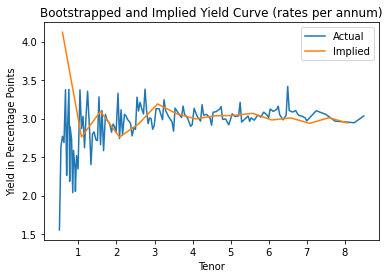

In [16]:
plt.plot(rates[0.5:8.5] * 100)
plt.plot(implied_rates_df * 100)
plt.title('Bootstrapped and Implied Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')
plt.legend(['Actual', 'Implied'])

We can see how the dedication will match the term structure of interest as each can be a function of their cahsflows and if we are essentially investing in the bonds that make up the term structure, will be very close to it but not exactly. We will find the cheapest "path" through the term structure, based on our liabilties.

## Implied Rates

In [17]:
md(''' 

<center>

{}

'''.format((implied_rates_df*100).to_markdown(colalign = ("right",)))
)

 

<center>

|   ttm |   implied_rate |
|------:|---------------:|
|  0.58 |        4.12182 |
|  1.08 |        2.76191 |
|  1.58 |        3.09323 |
|  2.08 |        2.76068 |
|  2.58 |        2.93103 |
|  3.08 |        3.1905  |
|  3.58 |        3.06338 |
|  4.08 |        2.99587 |
|  4.58 |        3.03655 |
|  5.08 |        3.04075 |
|  5.58 |        3.06863 |
|  6.08 |        2.98214 |
|  6.58 |        3.00874 |
|  7.08 |        2.93848 |
|  7.58 |        3.01135 |
|  8.08 |        2.94306 |



# Immunization Portfolio

Formulate a linear programming model to find the lowest cost bond immunized portfolio that matches the present value, duration, and convexity of a stream of liabilities. Assume that no short rates are allowed. What is the cost of your portfolio? How much would you save by using this immunization strategy instead of the dedication one? Is your portfolio immunized against non-parallel shifts in the term structure? Explain why or why not.

Now, we will approach this problem from an Immunization perspective. This means that we are going to find a new portfolio of bonds that match the Net Present Value, Duration, and Convexity of the stream of Liabilities required, while still minimizing the cost of the actual portfolio. For the purposes of this portfolio, we will assume that short rates aren't allowed. 

To achieve this, we first calculated the NPV, Duration, and Convexity of each of the bonds cash flows'. Then, to be able to match them to the NPV, Duration, and Convexity of the Liabilities (previously calculated), we multiply them by the amount of bonds to be bought, and sum them. This is explicitly stated in the Mathematical Formulation. 

## Mathematical Formulation

$$
\begin{split}
\text{min} \ \ \ &  \sum_{i=1}^NP_ix_i \\
\text{s.t.} \ \ \ & \sum_{i=1,...,n}NPV_i * x_i = NPV_{Liabilities}\\
& \sum_{i=1,...,n}Duration_i * x_i = Duration_{Liabilities}\\
& \sum_{i=1,...,n}Convexity_i * x_i = Convexity_{Liabilities}\\
& x_i \ge 0 \\
& \\
\text{where,} \\
& \text{$x_i$: quantity purchased of bond i;} \\
& \text{$P_i$: ask price of bond i.} \\
\end{split}
$$


## Code

In [18]:
'''
Aggregates cashflow matrix and ref data for immunization
---
Puts cashflow matrix into a dataframe for merging
merges possible bond ref data with cashflow matrix
cleans resulting dataframe
'''
cf_df = pd.DataFrame(cf_matrix, index=dec_var_names)

cf_df = pd.merge(                                                           # Combines possible bonds with cashflow matrix
    left = possibilities,                                                   # possible bonds - SAME DF AS DEDICATION
    right = cf_df,                                                          # Cashflow matrix - NP ARRAY FROM DEDICATION AS DF FOR MERGING
    how='inner',                                                            # Catches any missed bonds on merge
    left_on='ref_data',                                                     
    right_index=True                                                        # Casflow df indexed by bond name
)

cf_df = (cf_df
            .drop(['COUPON','period','face'],axis=1)                        # Drops unnecessary ref data
            .set_index('ref_data')                                          # Sets index to bond name
            .round({'ttm':round_to})                                        # rounds time to maturity to 2 decimal places -- allows use of derived term structure (indexed by hundredths)
        )



In [19]:
'''
Create Present Value, Duration, and Convexity factors for all possible time index based on derived rates curve
'''
t = rates.index
r = rates['rate']
npv_factor = np.exp(-r*t)
dur_factor = t*np.exp(-r*(t+1))
con_factor = t*(t+1)*np.exp(-r*(t+2))

In [20]:
'''
Calculates npv, duration, and convexity terms for all bonds consiuder in problem
'''
npvs=[]
durs=[]
cons=[]
for bond in cf_df.index:
    bond_df = cf_df.loc[bond]
    bond_ttm = bond_df.loc['ttm']
    bond_cf_stream = bond_df.loc[0:]
    eo_cfs = bond_cf_stream.idxmax()
    cpn_ttm = [(bond_ttm - 0.5*i).round(round_to) for i in range(eo_cfs+1)]
    bond_cf_ttm = pd.Series(data=bond_df.loc[0:eo_cfs].to_list(), index=reversed(cpn_ttm))

    bond_npv = sum([bond_cf_ttm.loc[i] * npv_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_dur = sum([bond_cf_ttm.loc[i] * dur_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_con = sum([bond_cf_ttm.loc[i] * con_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])

    npvs.append(bond_npv)
    durs.append(bond_dur)
    cons.append(bond_con)

immunization_df = pd.DataFrame([npvs, durs, cons], columns=cf_df.index, index=['npv','duration','convexity']).transpose()

In [21]:
'''
Solves immunization portfolio
'''
bond_count = LpVariable.dicts('Bonds',dec_var_names,lowBound=0)

immunization = LpProblem('immunization', LpMinimize)

immunization += lpSum([cf_df['px_ask'].loc[i] * bond_count[i] for i in dec_var_names])
immunization += lpSum([immunization_df['npv'].loc[i] * bond_count[i] for i in dec_var_names]) == npv
immunization += lpSum([immunization_df['duration'].loc[i] * bond_count[i] for i in dec_var_names]) == dur
immunization += lpSum([immunization_df['convexity'].loc[i] * bond_count[i] for i in dec_var_names]) == con

immunization.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/2f8f1b12da4b419a83a6b2f9375f71ae-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/2f8f1b12da4b419a83a6b2f9375f71ae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 1161 RHS
At line 1165 BOUNDS
At line 1166 ENDATA
Problem MODEL has 3 rows, 289 columns and 863 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 285 (-4) columns and 853 (-10) elements
0  Obj 0 Primal inf 50.241981 (3)
11  Obj 116.98769
Optimal - objective value 116.98769
After Postsolve, objective 116.98769, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 116.9876867 - 11 iterations time 0.002, P

1

In [22]:
ded_df = pd.DataFrame(
    [v.varValue for v in immunization.variables() if v.varValue != 0],
    index=[str(v.name[6:-8].replace('_', ' ') + v.name[-8:].replace('_', '/')) 
        if v.name[0] == 'B'
        else str(r'$\text{' + v.name[:-2] + '}' + v.name[-2:] + '$') for v in [g for g in immunization.variables() if g.varValue != 0]],
    columns=['Quantity']
    )
mature = ['20'+ i[-2:] + '-'+i[-8:-6] + '-'+i[-5:-3]
    if i[0] != 'B' 
    else '2100-01-01'
    for i in ded_df.index.tolist()]
bond_s_dis = ded_df.reset_index()
bond_s_dis['m'] = mature
bond_s_dis.set_index('m', inplace=True)
bond_s_dis.sort_index(inplace=True)
bond_s_dis.set_index('index', inplace=True)
bond_s_dis.index.name = ''

## Portfolio Allocation and Value

In [23]:
md(''' 

<center> Immunized Portfolio Value of ${:.2f} MM  </center> <br>


<center>

{}

'''.format(value(immunization.objective), bond_s_dis.to_markdown(colalign = ("right",)))
)

 

<center> Immunized Portfolio Value of $116.99 MM  </center> <br>


<center>

|                  |   Quantity |
|-----------------:|-----------:|
| T 7.250 08/15/22 |   0.184074 |
| T 6.625 02/15/27 |   0.612255 |
| T 6.125 08/15/29 |   0.226722 |



After solving the immunization problem, we find a portfolio with a lower cost than the Dedication one. This portfolio is $\$790,000$ cheapear, which represents a $0.67\%$ discount from the Dedication portfolio. 

A key consideration for this portfolio is the fact that given that the objective is only to match NPV, Duration, and Convexity, the Cash Flows don't match exactly to the liabilities. This means that even though the portfolio is cheaper, it involves certain money management. 

This portfolio is hedged against parallel interest rate moves, however it is still vulnerable to non-parallel shifts in the term structure. This is due to the fact that the actual cash flows don't match, and only the NPV, Duration, and Convexity. Therefore, if there were any non-parallel shifts, the NPV of the actual cash flows would be affected in a different manner than that of the Liabilities. 

# Dedication / Immunization Combined Strategy

Combine a cash matching strategy (dedication) for the liabilities for the first three years and an immunization strategy based on matching present value, duration and convexity for the liabilities during the last five years. Compare the characteristics of the three bond portfolios you have obtained. Explain which one you think is the best one and why.

Now we will try to find a portfolio that uses both of the Dedication and Immunization techniques used previously. We are using a Dedication strategy for the first 3 years and an Immunization for the last 5 years. Given that each of the liabilities is needed every 6 months, this means that Dedication will cover 6 periods, and Immunuization will cover the remaining 10 periods. 



## Mathematical Formulation

$$
\begin{split}
\text{min} \ \ \ &  z_0 + \sum_{i=1}^NP_ix_i \\
\\
\text{s.t.} \ \ \ & \sum_{i=1,\dots, \ n: \ M_i \ge t-1}C_{it}x_i + \sum_{i=1,\dots, \ n: \ M_i = t}100x_i + z_{t-1} -z_t = L_t \ \ \ \ t=\{1,\dots,16 \} \\
& \sum_{i=1,\dots,n}\text{NPV}_i * x_i = \text{NPV}_{\text{Liabilities}} \\
& \sum_{i=1,\dots,n}\text{Duration}_i * x_i = \text{Duration}_{\text{Liabilities}} \\
& \sum_{i=1,\dots,n} \text{Convexity}_i * x_i = \text{Convexity}_{\text{Liabilities}} \\
& x_i \geq 0 \\
& \\
\text{where, } \\
& z_t: \text{is the excess cash flow at the beginning of period t} \\
& x_i: \text{quantity purchased of bond i} \\
& P_i: \text{ask price of bond i} \\
& C_i: \text{coupon paid by bond i at time t} \\
\end{split}
$$





## Code

In [24]:
'''
Immunization part
Solves combined portfolio
'''

ded_period = 6
imm_period = 5
imm_start_period = len(data_prompt) - imm_period*2
imm_end_period = len(data_prompt)

bond_q = LpVariable.dicts('',dec_var_names,lowBound=0)
excess_cf = LpVariable.dicts('ExcessCF', periods[:ded_period+1], lowBound=0)


combined = LpProblem('Combined', LpMinimize)

combined += lpSum([cf_df['px_ask'][i] * bond_q[i] for i in dec_var_names]) + excess_cf[0]

for i in range(0,ded_period):
    combined += lpSum([cf_df[i][j]*bond_q[j] for j in dec_var_names]) + excess_cf[i]- excess_cf[i+1] == liabilities[i]

combined += lpSum([immunization_df['npv'][i] * bond_q[i] for i in dec_var_names]) == npv
combined += lpSum([immunization_df['duration'][i] * bond_q[i] for i in dec_var_names]) == dur
combined += lpSum([immunization_df['convexity'][i] * bond_q[i] for i in dec_var_names]) == con

combined.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/4457a473ed9745c59e54b20a32c3b2ae-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/4457a473ed9745c59e54b20a32c3b2ae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 14 COLUMNS
At line 2299 RHS
At line 2309 BOUNDS
At line 2310 ENDATA
Problem MODEL has 9 rows, 296 columns and 1994 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 9 (0) rows, 291 (-5) columns and 1979 (-15) elements
0  Obj 0 Primal inf 86.018841 (9)
28  Obj 117.2542
Optimal - objective value 117.2542
After Postsolve, objective 117.2542, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 117.2541995 - 28 iterations time 0.002, P

1

## Portfolio Allocation

In [25]:
'''
Print Solution to Combined portfolio
'''
ded_df = pd.DataFrame(
    [v.varValue for v in combined.variables() if v.varValue != 0],
    index=[str(v.name[1:9].replace('_', ' ') + v.name[9:].replace('_', '/')) 
        if v.name[0] != 'E'
        else str(r'$\text{' + v.name[:-2] + '}' + v.name[-2:] + '$') for v in [g for g in combined.variables() if g.varValue != 0]],
    columns=['Quantity']
    )
mature = ['20'+ i[-2:] + '-'+i[-8:-6] + '-'+i[-5:-3]
    if i[0] != 'E' 
    else '2100-01-01'
    for i in ded_df.index.tolist()]
bond_s_dis = ded_df.reset_index()
bond_s_dis['m'] = mature
bond_s_dis.set_index('m', inplace=True)
bond_s_dis.sort_index(inplace=True)
bond_s_dis.set_index('index', inplace=True)
bond_s_dis.index.name = ''

md(''' 

<center> Portfolio Value of ${:.2f} MM  </center> <br>

<center>

{}

'''.format(value(combined.objective), bond_s_dis.to_markdown(colalign = ("right", "center")))

)



 

<center> Portfolio Value of $117.25 MM  </center> <br>

<center>

|                  |  Quantity  |
|-----------------:|:----------:|
| T 7.250 08/15/22 | 0.0875426  |
| T 1.750 05/15/23 |  0.070716  |
| T 6.250 08/15/23 | 0.0613347  |
| T 2.500 05/15/24 | 0.0532515  |
| T 2.250 11/15/24 | 0.0739171  |
| T 2.750 05/15/25 | 0.0847487  |
| T 6.375 08/15/27 |  0.12234   |
| T 2.250 11/15/27 |  0.380657  |
| T 6.125 08/15/29 |  0.192785  |



The cost of this portfolio is in between the costs of the Dedication and the Immunization portfolios previously discussed at $\$117.25$. 

The advantage here mostly lies in that the cash flows exactly meet the liabilities for the first 6 periods, and therefore, there is no need for any money management at first. For this period the portfolio is also protected against any interest rate changes (parallel or otherwise). This would give the municipality some time to be assured to meet their liabilities. However, for the latter part of the term, there would be a need to do some money managment and the municipality would have to take the risk of non-parallel interest rate changes. 

For the small premium over the Immunized portfolio we consider it to be a better option. 

# Dedication Portfolio with Short Selling
## Prompt
The municipality would like to make a second bid (find a different portfolio of bonds). What is your best dedicated portfolio of risk-free bonds you can create *if short sales are allowed*? Did you find arbitrage opportunities? Did you take into consideration the bid-ask spread of the bonds? How would you take them in consideration and what is the result? Did you set limits in the transaction amounts? Discuss the practical feasibility of your solutions.

## Without Transaction Limits

### Mathematical Formulation



$$
\begin{split}
\text{min} \ \ \ &  z_0 + \sum_{i=1}^N P^{+}_i l_i - \sum_{i=1}^N P^{-}_i s_i \\
\\
\text{s.t.} \ \ \ & \sum_{i=1,\dots, \ n \ : \ M_i \geq t-1}[C_{it}l_i - C_{it}s_i] + \sum_{i=1,\dots, \ n: \ M_i = t} [100l_i - 100s_i] + (1+r_f)z_{t-1} -z_t = L_t \ \ \ \ t=\{1,\dots,16\} \\
& z_0 + \sum_{i=1}^N P^+_i l_i - \sum_{i=1}^N P^-_i s_i \ge 0 \\
& l_i, s_i \ge 0 \\
\\
\text{where,} \\
& L_t: \text{liability at time t} \\
& z_t: \text{is the excess cash flow at the beginning of period t} \\
& l_i: \text{quantity bought long of bond i} \\
& s_i: \text{quantity sold short of bond i} \\
& P^+_i: \text{ask price of bond i} \\
& P^-_i: \text{bid price of bond i} \\
& C_i: \text{coupon paid by bond i at time t} \\
\end{split}
$$

Here we are minimizing the cost of the portfolio as our objective but bring into account the ability to short sell bonds. This causes us to use auxilary variables $l_i$ and $s_i$ where these two now account for long amounts and short amounts respectively. Seeing this to be the case, we naturally look for arbitrage opportunities with the bid-ask spreads. If we are allowed to use this extra cash obtained from the short to fund the pruchases of our long positions, and we are allowed to keep the difference when all $L_t$ have been paid for $t \in \{1,\dots,16 \}$, we are also maximizing profit.

**NOTE**: Please remember a negative value or a value of 0 would imply a arbitrage opportunity because it would show a surplus from our short sell cashflows. Also, we are using the ask and bid for long and short position, repsectively.  

### Code

In [26]:
'''
Solves short portfolio
'''
short_limit = 0.5
long_q = LpVariable.dicts('Long',dec_var_names,lowBound=0)
short_q = LpVariable.dicts('Short',dec_var_names,lowBound=0)
excess_cfs = LpVariable.dicts('ExcessCF', periods, lowBound=0)

short = LpProblem('Short', LpMinimize)

#Objective 
short += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names])+ excess_cfs[0]

#Bounds Objective to be NonNegative - Municipality can't profit from short trading - At best they get their dedication portfolio free
short += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]+ excess_cfs[0]) >= 0

#Liabilities Constraints
for i in range(0,len(cf_matrix[0])):
    short += lpSum([cf_df[i][j]*long_q[j] - cf_df[i][j]*short_q[j] for j in dec_var_names]) + excess_cfs[i] - excess_cfs[i+1] == liabilities[i]

short.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/9945a6e4591f4ab88c274760bd838474-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/9945a6e4591f4ab88c274760bd838474-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22 COLUMNS
At line 4309 RHS
At line 4327 BOUNDS
At line 4328 ENDATA
Problem MODEL has 17 rows, 595 columns and 3707 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (0) rows, 584 (-11) columns and 3676 (-31) elements
0  Obj 0 Primal inf 1.2899668 (16) Dual inf 1151796.9 (284)
0  Obj 0 Primal inf 1.2899668 (16) Dual inf 1.205329e+14 (294)
27  Obj -9.094947e-13
Optimal - objective value -9.094947e-13
After Postsolve, objective -9.094947e

1

### Portfolio Allocation

In [27]:
'''
Print Solution to Short portfolio
'''
'''
Print Solution to Short portfolio with Shorting Limit
'''
bonds_short_l = pd.DataFrame(
    [v.varValue for v in short.variables() if v.varValue != 0],
    index=[str(v.name[:-8].replace('_', ' ')+v.name[-8:].replace('_', '/')) 
        if v.name[0] == 'L' or v.name[0] =='S'
        else str(r'$\text{' + v.name[:-2] + '}' + v.name[-2:] + '$') for v in [g for g in short.variables() if g.varValue != 0]],
    columns=['Quantity']
    )
mature = ['20'+ i[-2:] + '-'+i[-8:-6] + '-'+i[-5:-3]
    if i[0] == 'L' or i[0] == 'S' 
    else '2100-01-01'
    for i in bonds_short_l.index.tolist()]
bond_s_dis = bonds_short_l.reset_index()
bond_s_dis['m'] = mature
bond_s_dis.set_index('m', inplace=True)
bond_s_dis.sort_index(inplace=True)
bond_s_dis.set_index('index', inplace=True)
bond_s_dis.index.name = ''

md(''' 
<center> Portfolio Value of ${:.2f} MM  </center> <br>

<center>

{}


'''.format(value(short.objective), bond_s_dis.to_markdown(colalign = ("right", "center")))
)


 
<center> Portfolio Value of $-0.00 MM  </center> <br>

<center>

|                        |   Quantity   |
|-----------------------:|:------------:|
| Short T 0.000 06/16/22 |   2.04863    |
| Short T 0.137 12/31/22 |   63.2136    |
|  Long T 7.125 02/15/23 |   61.1449    |
|  Long T 6.250 08/15/23 |  0.0563529   |
|  Long T 2.000 05/31/24 |  0.0481139   |
|  Long T 1.500 11/30/24 |  0.0685951   |
|  Long T 7.625 02/15/25 |   0.154094   |
|  Long T 0.750 05/31/26 |   0.104984   |
|  Long T 6.750 08/15/26 |  0.0753781   |
|  Long T 6.625 02/15/27 |  0.0479221   |
|  Long T 6.375 08/15/27 |  0.0395095   |
|  Long T 2.875 05/15/28 |  0.0607689   |
|  Long T 5.500 08/15/28 |  0.0816424   |
|  Long T 5.250 02/15/29 |  0.0638876   |
|  Long T 6.125 08/15/29 |  0.0755646   |
|  Long T 6.250 05/15/30 |  0.0678788   |
|    $\text{ExcessCF}_6$ |   7.49844    |
|    $\text{ExcessCF}_3$ | -1.38988e-09 |




### Discussion

By the results above, we are able to see that there is an arbitrage opportunity and in the mathematical sense, is feasible, but for the fact that the 63+ MM is an extremely large transaction for any single issuance. The latter makes this solution infeasible in a real world application. Because of this we have created a formulation where the set a limit on the transaction amounts.  

## With Transaction Limits

By setting a transaction limit to the amount of bonds sold short, we eliminate the arbitrage opportunity found in the previous portfolio. We do this to generate a more realistic version of what a municipality can expect from a real life transaction that also involves the opportunity to sell bonds short. We assumed a transaction limit of $50\%$, meaning that the total amount of short selling cannot be greater than $50\%$ of the total amount bought long. 

### Mathematical Formulation

$$
\begin{split}
\text{min} \ \ \ &  z_0 + \sum_{i=1}^N P^+_il_i - \sum_{i=1}^N P^-_is_i \\
\text{s.t.} \ \ \ & \sum_{i=1,\dots, \ n : \ M_i \ge t-1}C_{it}l_i - C_{it}s_i + \sum_{i=1,...,n:M_i = t} 100l_i - 100s_i + z_{t-1} -z_t = L_t  \ \ \ \ t=\{1,\dots,16 \} \\
& z_0 + \sum_{i=1}^N P^+_i l_i - \sum_{i=1}^N P^-_i s_i \ge 0 \\
& \sum_{i=1}^N P^-_i s_i \le SL* \sum_{i=1}^N P^+_i l_i  \\
\\
\text{where, } \\
& \text{$L_t$: liability at time t} \\
& \text{$z_t$: is the excess cash flow at the beginning of period t} \\
& \text{$l_i$: quantity bought long of bond i} \\
& \text{$s_i$: quantity sold short of bond i} \\
& \text{$P^+_i$: ask price of bond i} \\
& \text{$P^-_i$: bid price of bond i} \\
& \text{$C_i$: coupon paid by bond i at time t} \\
& \text{$SL$: Short limit as a percentage of the amount bought long} \\
\end{split}
$$

### Code

\scriptsize

In [28]:
'''
Solves short portfolio with a Shorting Limit
'''
short_limit = 0.5
long_q = LpVariable.dicts('Long',dec_var_names,lowBound=0)
short_q = LpVariable.dicts('Short',dec_var_names,lowBound=0)
excess_cfs = LpVariable.dicts('ExcessCF', periods, lowBound=0)

short_l = LpProblem('Short', LpMinimize)

#Objective 
short_l += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names])+ excess_cfs[0]

#Bounds Objective to be Positive - Municipality can't profit from short trading - At best they get their dedication portfolio free
short_l += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]+ excess_cfs[0]) >= 0

#Adds a Short Limit as a % of the Total Amount invested in Long Bonds
short_l += lpSum([cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]) <= lpSum([cf_df['px_ask'][i] * long_q[i] for i in dec_var_names])*short_limit

#Liabilities Constraints
for i in range(0,len(cf_matrix[0])):
    short_l += lpSum([cf_df[i][j]*long_q[j] - cf_df[i][j]*short_q[j] for j in dec_var_names]) + excess_cfs[i] - excess_cfs[i+1] == liabilities[i]

short_l.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/2cad557085a647cf9ad2569bf5ec7cbf-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/2cad557085a647cf9ad2569bf5ec7cbf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 23 COLUMNS
At line 4888 RHS
At line 4907 BOUNDS
At line 4908 ENDATA
Problem MODEL has 18 rows, 595 columns and 4285 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 18 (0) rows, 584 (-11) columns and 4244 (-41) elements
0  Obj 0 Primal inf 1.2899668 (16) Dual inf 1151796.9 (284)
0  Obj 0 Primal inf 1.2899668 (16) Dual inf 1.205329e+14 (294)
31  Obj 115.62473
Optimal - objective value 115.62473
After Postsolve, objective 115.62473, infeasi

1

\normalsize

### Portfolio Allocation and Value

In [29]:
'''
Print Solution to Short portfolio with Shorting Limit
'''
bonds_short_l = pd.DataFrame(
    [v.varValue for v in short_l.variables() if v.varValue != 0],
    index=[str(v.name[:-8].replace('_', ' ')+v.name[-8:].replace('_', '/')) 
        if v.name[0] == 'L' or v.name[0] =='S'
        else str(r'$\text{' + v.name[:-2] + '}' + v.name[-2:] + '$') for v in [g for g in short_l.variables() if g.varValue != 0]],
    columns=['Quantity']
    )
mature = ['20'+ i[-2:] + '-'+i[-8:-6] + '-'+i[-5:-3]
    if i[0] == 'L' or i[0] == 'S' 
    else '2100-01-01'
    for i in bonds_short_l.index.tolist()]
bond_s_dis = bonds_short_l.reset_index()
bond_s_dis['m'] = mature
bond_s_dis.set_index('m', inplace=True)
bond_s_dis.sort_index(inplace=True)
bond_s_dis.set_index('index', inplace=True)
bond_s_dis.index.name = ''
md(''' 

<center> Portfolio Value of ${:.2f} MM  </center> <br>

<center>

{}
'''.format(value(short_l.objective), bond_s_dis.to_markdown(colalign = ("right", "center")))
)

 

<center> Portfolio Value of $115.62 MM  </center> <br>

<center>

|                        |   Quantity   |
|-----------------------:|:------------:|
|  Long T 7.250 08/15/22 |  0.0507575   |
|  Long T 7.125 02/15/23 |  0.0325975   |
| Short T 0.125 06/30/23 |   1.18926    |
|  Long T 6.250 08/15/23 |   1.21302    |
|  Long T 2.000 05/31/24 |  0.0509223   |
|  Long T 1.500 11/30/24 |  0.0714316   |
|  Long T 7.625 02/15/25 |  0.0819673   |
|  Long T 6.875 08/15/25 |  0.0750923   |
|  Long T 0.750 05/31/26 |   0.107674   |
|  Long T 6.750 08/15/26 |  0.0780774   |
|  Long T 6.625 02/15/27 |  0.0507125   |
|  Long T 6.375 08/15/27 |  0.0423924   |
|  Long T 1.250 05/31/28 |  0.0637436   |
|  Long T 5.500 08/15/28 |   0.084142   |
|  Long T 2.875 04/30/29 |  0.0664559   |
|  Long T 6.125 08/15/29 |  0.0774112   |
|  Long T 0.625 05/15/30 |  0.0697819   |
|    $\text{ExcessCF}_3$ | -1.38988e-09 |


### Discussion

By doing this we found a portfolio with a lower cost than the optimal found without the option of short selling. Even with the transaction limit set by us, and by taking into account the bid-ask spread, the cost of the portfolio decreases by close to $2\%$ to $\$115.62 M$. Even with the set transaction limits, we find this to be a better portfolio than without the opportunity to short sell. 

However, we consider the feasability of this portfolio to be low given that we are focusing on the needs of a Municipality, and it is not common for them to use short selling, considering the risk involved. 

# Immunization and Short Selling

Consider proposing a new portfolio of bonds using any additional consideration or change to the model that you see fit. For example, can you do something to make your portfolio of bonds immune to nonparallel changes in the term structure. Is there a better way to combine the techniques you used before. Explain clearly what you do and your results.

Now we are going to try to find an even better portfolio in terms of cost by using the strategies mentioned before. We know that an immunization portfolio is cheaper than a dedication one, and we know that the opportunity to short sell bonds reduces the cost even more. Therefore we will now approach the problem from an Immunization perspective while allowing the opportunity to short sell some of the bonds with the same transaction limit as set before. This states that the total amount of short selling cannot be greater than $50\%$ of the total amount bought long.

## Mathematical Formulation

$$
\begin{split}
\text{min} \ \ \ &  \sum_{i=1}^NP^+_il_i - P^-_is_i \\
\text{s.t.} \ \ \ & \sum_{i=1,...,n}NPV_i * x_i = NPV_{Liabilities}\\
& \sum_{i=1,...,n}Duration_i * l_i - Duration_i * s_i = Duration_{Liabilities}\\
& \sum_{i=1,...,n}Convexity_i * l_i - Convexity_i * s_i = Convexity_{Liabilities}\\
& \sum_{i=1}^NP^-_is_i \le SL*\sum_{i=1}^NP^+_il_i  \\
& l_i, s_i \ge 0 \\
\\
\text{where,} \\
& \text{$l_i$: quantity bought long of bond i;} \\
& \text{$s_i$: quantity sold short of bond i;} \\
& \text{$P^+_i$: ask price of bond i.} \\
& \text{$P^-_i$: bid price of bond i.} \\
& \text{$SL$: Short limit as a percentage of the amount bought long} \\
\end{split}
$$

## Code

\scriptsize

In [30]:
'''
Immunization With Shorting Available (Limited)
'''

long_q = LpVariable.dicts('Long',dec_var_names,lowBound=0)
short_q = LpVariable.dicts('Short',dec_var_names,lowBound=0)


imm_s = LpProblem('Immunized_Short', LpMinimize)

imm_s += lpSum([cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]) <= lpSum([cf_df['px_ask'][i] * long_q[i] for i in dec_var_names])*short_limit

imm_s += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names])
imm_s += lpSum([immunization_df['npv'].loc[i] * long_q[i] - immunization_df['npv'].loc[i] * short_q[i] for i in dec_var_names]) == npv
imm_s += lpSum([immunization_df['duration'].loc[i] * long_q[i] - immunization_df['duration'].loc[i] * short_q[i] for i in dec_var_names]) == dur
imm_s += lpSum([immunization_df['convexity'].loc[i] * long_q[i] - immunization_df['convexity'].loc[i] * short_q[i] for i in dec_var_names]) == con

imm_s.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/71a3565c138246f0bef493146c6b7711-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/71a3565c138246f0bef493146c6b7711-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 2892 RHS
At line 2897 BOUNDS
At line 2898 ENDATA
Problem MODEL has 4 rows, 578 columns and 2304 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 578 (0) columns and 2304 (0) elements
0  Obj 0 Primal inf 50.245861 (3) Dual inf 81751.292 (289)
0  Obj 0 Primal inf 50.245861 (3) Dual inf 5.5734171e+13 (289)
14  Obj 114.2373
Optimal - objective value 114.2373
Optimal objective 114.2372977 - 14 iterations time 0.00

1

\normalsize

## Portfolio Allocation

In [31]:
'''
Print Solution to Short Immunized portfolio with Limits (Same Limit as Last Prob)
'''
imms_bonds = pd.DataFrame(
    [v.varValue for v in imm_s.variables() if v.varValue != 0],
    index=[str(v.name[:-8].replace('_', ' ')+v.name[-8:].replace('_', '/')) for v in imm_s.variables() if v.varValue != 0],
    columns=['Quantity']
    )

md(''' 

<center> Portfolio Value of ${:.2f} MM  </center> <br>

<center>

{}

'''.format(value(imm_s.objective), imms_bonds[imms_bonds['Quantity']!=0].to_markdown(colalign = ("right",)))
)

 

<center> Portfolio Value of $114.24 MM  </center> <br>

<center>

|                        |   Quantity |
|-----------------------:|-----------:|
|  Long T 6.125 08/15/29 |   0.841719 |
|  Long T 6.625 02/15/27 |   0.992871 |
|  Long T 7.250 08/15/22 |   0.118033 |
| Short T 5.250 11/15/28 |   1.00929  |



## Discussion

Using the tools we discussed throughout the entire report, we find that we can lower the cost slightly more. Therefore, if our focus is to minimize cost, we would recommend an Immunization strategy that considers the opportunity to short sell some of the bonds (for this particular portfolio, only one). 

This portfolio matches the NPV, Duration, and Convexity of the Libilities required, and is covered against parallel interest rate changes. And while it does need money management, the cost of this portfolio is $\$114.24 M$. Which, not considering the arbitrage opportunity found in the dedication portfolio without shorting limits, is the lowest cost portfolio we could find. 